In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

### Load Dataset and Convert Time-Series Format

In [20]:
df = pd.read_csv("./citibike_2023.csv")
df['datetime'] = pd.to_datetime(df['started_at'])
df.set_index('datetime', inplace=True)
df_resampled = df.resample('D').size() 

C:\Users\brian\AppData\Local\Temp\ipykernel_36124\3763178379.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./citibike_2023.csv")


In [21]:
train, test = train_test_split(df_resampled, test_size=0.2, shuffle=False)

### Base ARIMA Model

In [22]:
arima_model = ARIMA(train, order=(5, 1, 0))  # Tune p, d, q
arima_fit = arima_model.fit()

In [23]:
arima_forecast = arima_fit.forecast(steps=len(test))


### Base ARIMA Model Evaluation

In [24]:
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)
print(f"ARIMA RMSE: {arima_rmse}, ARIMA MAE: {arima_mae}")


ARIMA RMSE: 1345.9887997133783, ARIMA MAE: 1147.9516488372533


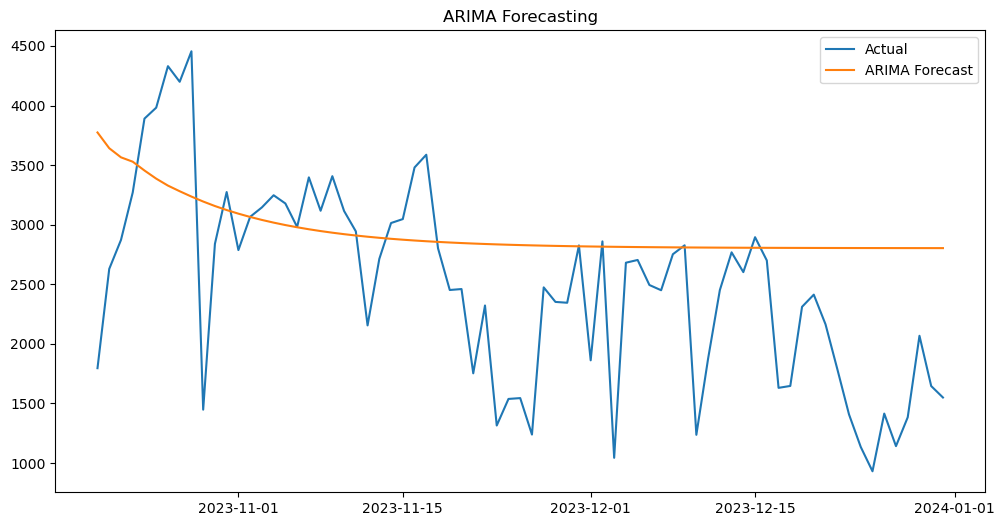

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecasting")
plt.show()

### ARIMA Hyperparameter Tuning

In [26]:
def tune_arima(train, p_values, d_values, q_values):
    best_rmse = float('inf')
    best_params = None
    best_model = None

    for params in ParameterGrid({'p': p_values, 'd': d_values, 'q': q_values}):
        try:
            # Fit ARIMA model
            model = ARIMA(train, order=(params['p'], params['d'], params['q']))
            model_fit = model.fit()
            
            # Forecast and evaluate
            forecast = model_fit.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, forecast))
            
            # Update best model if this one is better
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params
                best_model = model_fit
        except Exception as e:
            continue

    print(f"Best ARIMA Parameters: {best_params}, Best RMSE: {best_rmse}")
    return best_model, best_params

In [27]:
p_values = [0, 1, 2, 3, 4]
d_values = [0, 1]
q_values = [0, 1, 2]

In [28]:
best_arima_model, best_arima_params = tune_arima(train, p_values, d_values, q_values)


c:\Users\brian\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\brian\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\brian\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\brian\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\brian\anaconda3\Lib\s

Best ARIMA Parameters: {'d': 0, 'p': 4, 'q': 0}, Best RMSE: 876.0514899666157


In [29]:
arima_forecast = best_arima_model.forecast(steps=len(test))

### Best ARIMA Model Evaluation

In [30]:
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)

In [31]:
print(f"ARIMA RMSE: {arima_rmse}, ARIMA MAE: {arima_mae}")


ARIMA RMSE: 876.0514899666157, ARIMA MAE: 670.5230204998012


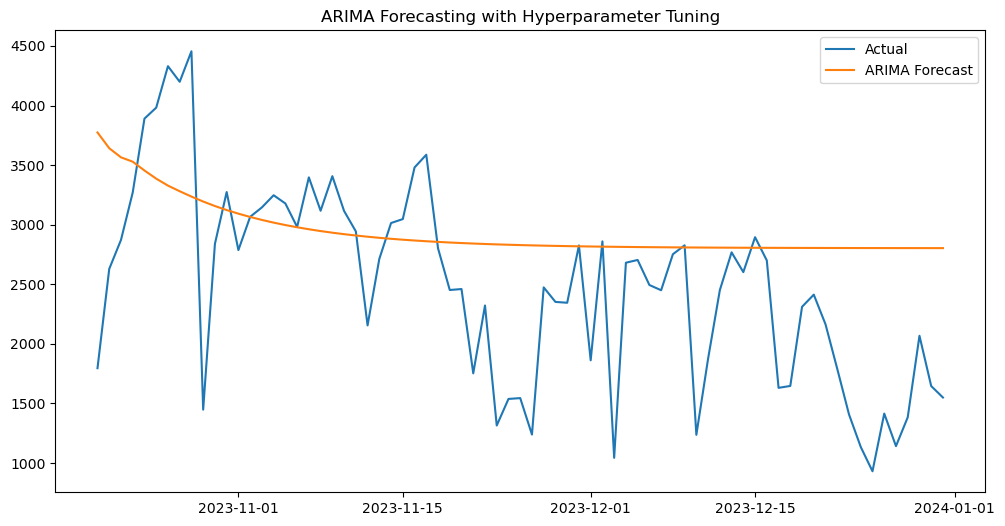

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecasting with Hyperparameter Tuning")
plt.show()

### Base SARIMA Model

In [34]:
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
model_fit = sarima.fit(disp=False)

In [35]:
sarima_forecast = model_fit.forecast(steps=len(test))

### Base SARIMA Model Evaluation

In [36]:
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
sarima_mae = mean_absolute_error(test, sarima_forecast)
print(f"SARIMA RMSE: {sarima_rmse}, SARIMA MAE: {sarima_mae}")

SARIMA RMSE: 1433.9570827782384, SARIMA MAE: 1218.4955014724133


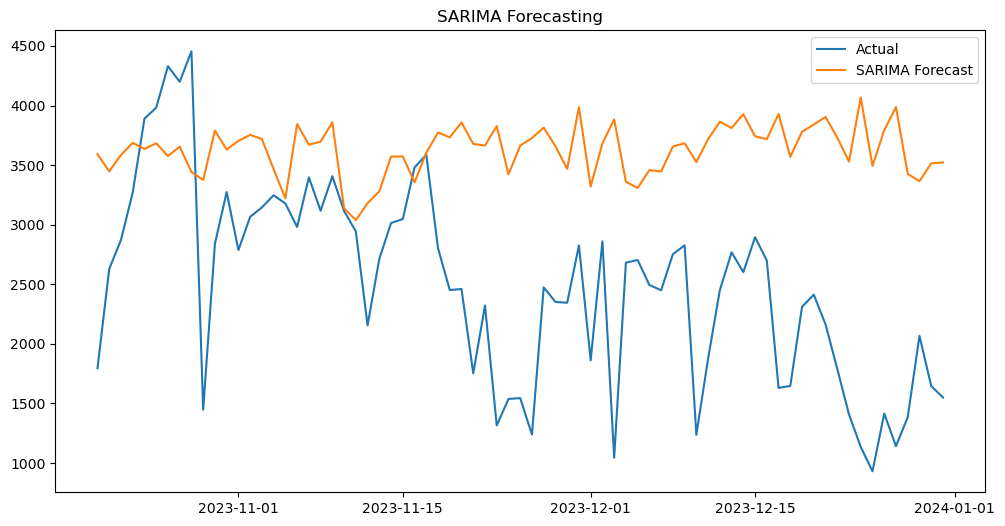

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title("SARIMA Forecasting")
plt.show()

### SARIMA Hyperparameter Tuning

In [40]:
def tune_sarima(train, p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods):
    best_rmse = float('inf')
    best_params = None
    best_model = None

    for params in ParameterGrid({
        'p': p_values, 'd': d_values, 'q': q_values,
        'P': P_values, 'D': D_values, 'Q': Q_values, 's': seasonal_periods
    }):
        try:
            # Fit SARIMA model
            model = SARIMAX(train,
                            order=(params['p'], params['d'], params['q']),
                            seasonal_order=(params['P'], params['D'], params['Q'], params['s']))
            model_fit = model.fit(disp=False)
            
            # Forecast and evaluate
            forecast = model_fit.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, forecast))
            
            # Update best model if this one is better
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params
                best_model = model_fit
        except Exception as e:
            continue

    print(f"Best SARIMA Parameters: {best_params}, Best RMSE: {best_rmse}")
    return best_model, best_params

In [41]:
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1]
seasonal_periods = [24]

In [42]:
best_sarima_model, best_sarima_params = tune_sarima(train, p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods)


c:\Users\brian\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\brian\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\brian\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\brian\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\bria

Best SARIMA Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 2, 'q': 0, 's': 24}, Best RMSE: 650.276532817379


In [43]:
sarima_forecast = best_sarima_model.forecast(steps=len(test))


### Best SARIMA Model Evaluation

In [44]:
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
sarima_mae = mean_absolute_error(test, sarima_forecast)

In [45]:
print(f"SARIMA RMSE: {sarima_rmse}, SARIMA MAE: {sarima_mae}")

SARIMA RMSE: 650.276532817379, SARIMA MAE: 516.3278908785711


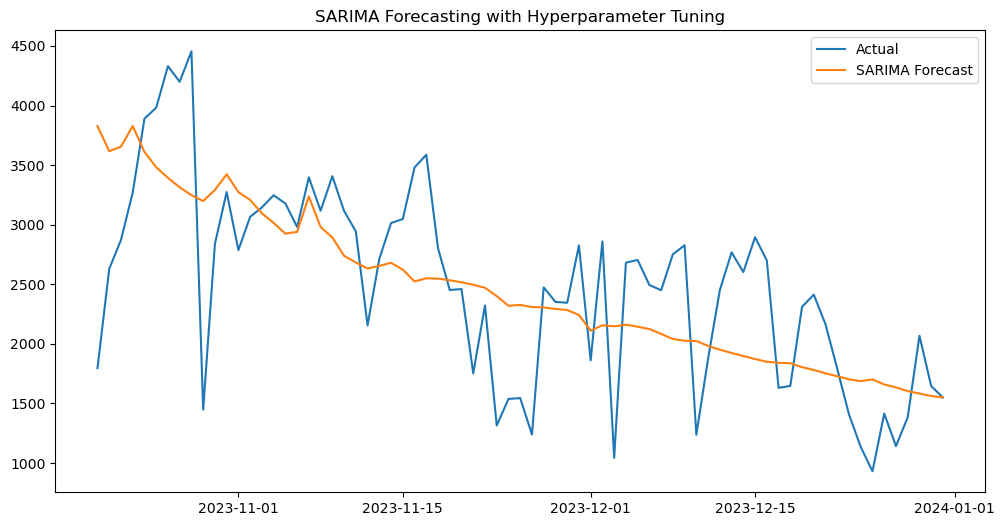

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title("SARIMA Forecasting with Hyperparameter Tuning")
plt.show()

### Compare Performance of ARIMA and SARIMA with Best Hyperparameters

In [47]:
print(f"SARIMA RMSE: {sarima_rmse}, SARIMA MAE: {sarima_mae}")
print(f"ARIMA RMSE: {arima_rmse}, ARIMA MAE: {arima_mae}")


SARIMA RMSE: 650.276532817379, SARIMA MAE: 516.3278908785711
ARIMA RMSE: 876.0514899666157, ARIMA MAE: 670.5230204998012


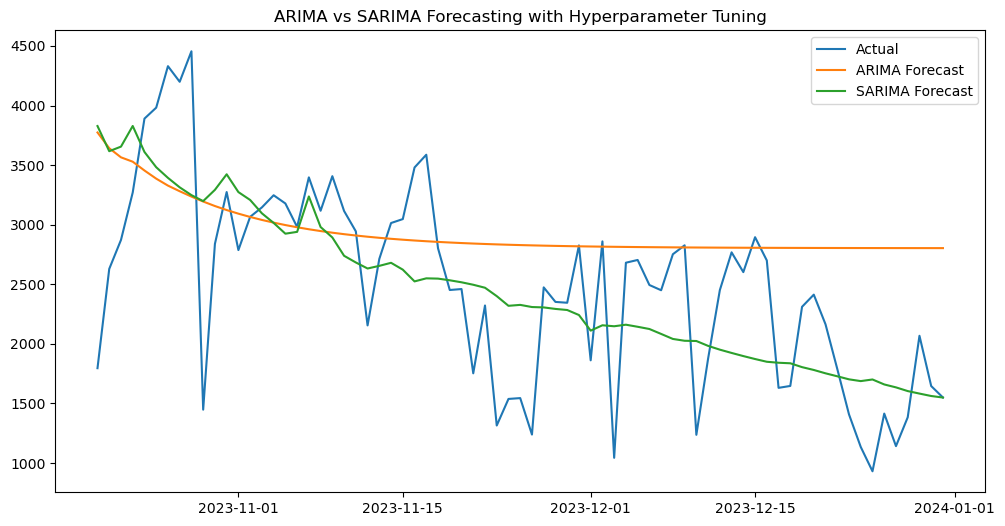

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title("ARIMA vs SARIMA Forecasting with Hyperparameter Tuning")
plt.show()